In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
flow = pd.read_pickle('data/soroe_13_19.pkl')
weather = pd.read_pickle('data/weather13_19.pkl')

In [3]:
flow = flow[flow.index.date > datetime.date(2013, 11, 28)]

In [4]:
weather = weather.resample('H').pad()

In [5]:
#data = pd.concat([flow, weather], axis=1, join='inner')
data = weather

## Checking corr-coefficients of different features

In [6]:
#np.corrcoef(data.drought, data.temp_mean)

In [7]:
#np.corrcoef(data.drought, data.rain_mm)

In [8]:
#np.corrcoef(data.temp_mean, data.rain_mm)

Rain and drought seem to be a good fit, since their correlation is pretty small. Temperature and rain has even lower correlation, but we know that drought is a better explanator of flow than temp

In [9]:
data_daily = data.resample('D').mean()

In [10]:
#np.corrcoef(data_daily.flow, data_daily.drought)

In [11]:
#np.corrcoef(data_daily.flow,data_daily.temp_mean)

In [12]:
#np.corrcoef(data_daily.flow,data_daily.rain_mm)

## Creating features combinations of rain data

In [13]:
data_daily['rain_1'] = data_daily.rain_mm.shift()
data_daily['rain_2'] = data_daily.rain_mm.shift(2)
data_daily['rain_3'] = data_daily.rain_mm.shift(3)
data_daily['rain_4'] = data_daily.rain_mm.shift(4)
data_daily['rain_5'] = data_daily.rain_mm.shift(5)
data_daily['rain_6'] = data_daily.rain_mm.shift(6)
data_daily['rain_7'] = data_daily.rain_mm.shift(7)

In [14]:
data_daily['rain_2d'] = data_daily.rain_1 + data_daily.rain_2 == 0
data_daily['rain_3d'] = data_daily.rain_1 + data_daily.rain_2 + data_daily.rain_3 == 0
data_daily['rain_4d'] = data_daily.rain_1 + data_daily.rain_2 + data_daily.rain_3 + data_daily.rain_4 == 0
data_daily['rain_5d'] = data_daily.rain_1 + data_daily.rain_2 + data_daily.rain_3 + data_daily.rain_4 + data_daily.rain_5 == 0
data_daily['rain_6d'] = data_daily.rain_1 + data_daily.rain_2 + data_daily.rain_3 + data_daily.rain_4 + data_daily.rain_5 + data_daily.rain_6 == 0
data_daily['rain_7d'] = data_daily.rain_1 + data_daily.rain_2 + data_daily.rain_3 + data_daily.rain_4 + data_daily.rain_5 + data_daily.rain_6 + data_daily.rain_7 == 0

In [15]:
#data_daily['flow_1'] = data_daily.flow.shift()
#data_daily['delta_flow'] = data_daily.flow - data_daily.flow_1

In [16]:
#np.corrcoef(data_daily.delta_flow[1:], data_daily.drought[1:])

In [17]:
#np.corrcoef(data_daily.flow[7:], data_daily.rain_3d[7:])

Based on preliminary inspections of data, the obvious strategy is to use the rain_xd variables, and the drought, since their correlation is relatively small, and at the same time, they both capture some of the variance on flow data. 

Apart from these features, i will obviously still use 'hour' and 'nwd' since they capture the seasonality very neatly

## Turning it into a class 

In [18]:
class RainFeatures(object):
    
    def __init__(self, data, num_of_shifts):
        self.data = data
        self.num_of_shifts = num_of_shifts
        
    def make_it_rain(self):
        """
        Sums up the amount of rain that has fallen the last i days
        """
        
        for i in range(1, self.num_of_shifts+1):
            
            self.data[f'rain_{i}'] = self.data.rain_mm.shift(24*i)
            
        return self.data
    
    def days_without_rain(self):
        """
        Makes a dummy-variable, that is 1 if it hasn't rained for i days, and 0 if it has
        """
        
        
        rain_dict = {}
        for i in range(1, self.num_of_shifts+1):
            
            self.data[f'rain_{i}d'] = 0
            
            j = 1
            while j <= i:
                self.data[f'rain_{i}d'] = self.data[f'rain_{i}d'] + self.data[f'rain_{i}']
                j += 1
                
            self.data[f'rain_{i}d'] = self.data[f'rain_{i}d'] == 0
            
        return self.data
            

In [19]:
rf = RainFeatures(data, 7)
rf.make_it_rain()
rf.days_without_rain()

rain_mm   drought  temp_low  temp_high    rain_1  \
2013-01-01 00:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 01:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 02:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 03:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 04:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 05:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 06:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 07:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 08:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 09:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 10:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 11:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 12:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 13:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 14:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 15:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 16:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 17:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 18:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 19:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 20:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 21:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 22:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-01 23:00:00  2.842503  0.000000       2.6   7.600000       NaN   
2013-01-02 00:00:00  0.358545  0.000000       2.7   5.700000  2.842503   
2013-01-02 01:00:00  0.358545  0.000000       2.7   5.700000  2.842503   
2013-01-02 02:00:00  0.358545  0.000000       2.7   5.700000  2.842503   
2013-01-02 03:00:00  0.358545  0.000000       2.7   5.700000  2.842503   
2013-01-02 04:00:00  0.358545  0.000000       2.7   5.700000  2.842503   
2013-01-02 05:00:00  0.358545  0.000000       2.7   5.700000  2.842503   
...                       ...       ...       ...        ...       ...   
2019-08-21 19:00:00  0.231685  6.461836      10.2  20.299999  0.408201   
2019-08-21 20:00:00  0.231685  6.461836      10.2  20.299999  0.408201   
2019-08-21 21:00:00  0.231685  6.461836      10.2  20.299999  0.408201   
2019-08-21 22:00:00  0.231685  6.461836      10.2  20.299999  0.408201   
2019-08-21 23:00:00  0.231685  6.461836      10.2  20.299999  0.408201   
2019-08-22 00:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 01:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 02:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 03:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 04:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 05:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 06:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 07:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 08:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 09:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 10:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 11:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 12:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 13:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 14:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 15:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 16:00:00  0.094195  6.871478       9.1  23.600000  0.231685   
2019-08-22 17:00:00  0.094

In [20]:
data.to_pickle('data/weather_features')

In [21]:
plt.plot(flow)

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [22]:
flow[flow.index.year == 2013] = flow[flow.index.year == 2013].apply(lambda x : x*(1-0.06))
flow[flow.index.year == 2014] = flow[flow.index.year == 2014].apply(lambda x : x*(1-0.06))
flow[flow.index.year == 2015] = flow[flow.index.year == 2015].apply(lambda x : x*(1-0.21))
flow[flow.index.year == 2016] = flow[flow.index.year == 2016].apply(lambda x : x*(1-0.14))
flow[flow.index.year == 2017] = flow[flow.index.year == 2017].apply(lambda x : x*(1-0.11))
flow[flow.index.year == 2018] = flow[flow.index.year == 2018].apply(lambda x : x*(1-0.14))

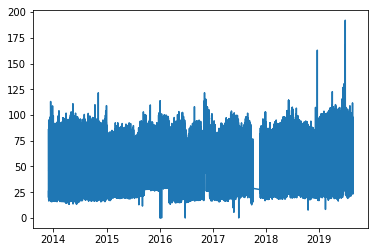

In [23]:
plt.plot(flow)

In [24]:
flow.to_pickle('data/flow_deleaked.pkl')